Rank the sensors according to their importance/predictive power in descending order
with respect to the class labels of the samples.

Importing the necessary modules. 

In [37]:
import os,numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
import pandas as pd
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.ensemble import RandomForestClassifier

Changing csv file directory and importing the file to a pandas DataFrame. 

In [2]:
os.chdir('E://Datasets//Sensor//task') # swithcing the directory to path sepecified.
os.listdir()

['task_data.csv', 'task_description.txt']

In [3]:
sensor = pd.read_csv(os.path.join('task_data.csv'),header=0) # reading task_data.csv

In [4]:
sensor.head() # the file with all the features is loaded correctly with headers.

,sample index,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
0,sample0,1.0,0.834251,0.726081,0.535904,0.214896,0.873788,0.767605,0.111308,0.557526,0.599650,0.665569
1,sample1,1.0,0.804059,0.253135,0.869867,0.334285,0.604075,0.494045,0.833575,0.194190,0.014966,0.802918
2,sample2,1.0,0.694404,0.595777,0.581294,0.799003,0.762857,0.651393,0.075905,0.007186,0.659633,0.831009
3,sample3,1.0,0.783690,0.038780,0.285043,0.627305,0.800620,0.486340,0.827723,0.339807,0.731343,0.892359
4,sample4,1.0,0.788835,0.174433,0.348770,0.938244,0.692065,0.377620,0.183760,0.616805,0.492899,0.930969


In [5]:
# dropping the sample index as we won't need it for this task. 
sensor.drop('sample index',axis=1,inplace=True)

In [6]:
sensor.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
class_label    400 non-null float64
sensor0        400 non-null float64
sensor1        400 non-null float64
sensor2        400 non-null float64
sensor3        400 non-null float64
sensor4        400 non-null float64
sensor5        400 non-null float64
sensor6        400 non-null float64
sensor7        400 non-null float64
sensor8        400 non-null float64
sensor9        400 non-null float64
dtypes: float64(11)
memory usage: 34.5 KB


There are no null values. so we can proceed check descriptive statistics on our sensor dataframe

In [7]:
sensor.describe() 

,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.000000,0.523661,0.509223,0.481238,0.509752,0.497875,0.501065,0.490480,0.482372,0.482822,0.541933
std,1.001252,0.268194,0.276878,0.287584,0.297712,0.288208,0.287634,0.289954,0.282714,0.296180,0.272490
min,-1.000000,0.007775,0.003865,0.004473,0.001466,0.000250,0.000425,0.000173,0.003322,0.003165,0.000452
25%,-1.000000,0.299792,0.283004,0.235544,0.262697,0.249369,0.269430,0.226687,0.242848,0.213626,0.321264
50%,0.000000,0.534906,0.507583,0.460241,0.510066,0.497842,0.497108,0.477341,0.463438,0.462251,0.578389
75%,1.000000,0.751887,0.727843,0.734937,0.768975,0.743401,0.738854,0.735304,0.732483,0.740542,0.768990
max,1.000000,0.999476,0.998680,0.992963,0.995119,0.999412,0.997367,0.997141,0.998230,0.996098,0.999465


Based on the above data each feature seems to be normally distributed.
we start with a simple correlation between each of the sensor features against the class label to see if we see anything interesting.

In [8]:
corr = sensor.corr()

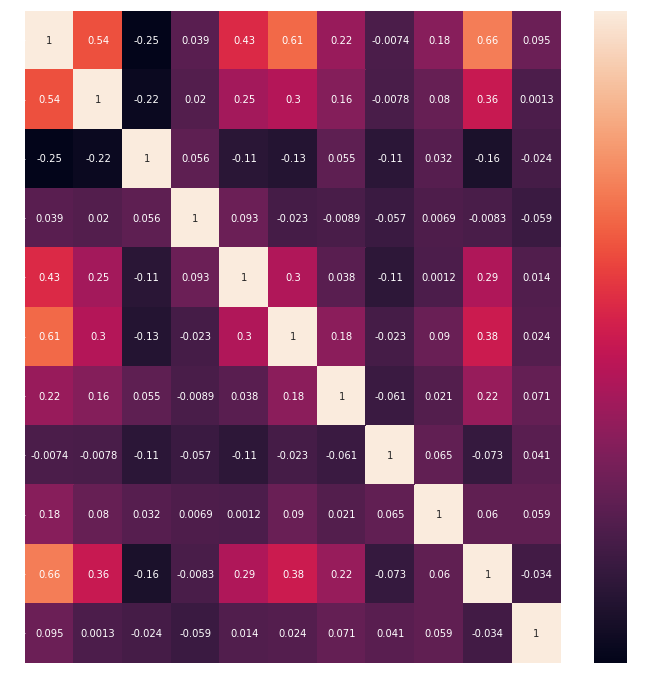

In [10]:
plt.figure(figsize=(12,12))
sns.heatmap(corr,annot=True)
plt.show()

Based on the above correlation map, Sensor0, sensor3,sensor4, and sensor8 are more positively correlated to the class label while sensor1 being negatively correlated to the response class label. 

Let's see if we have a balanced data for response value(class label). 

In [11]:
sensor.class_label.value_counts() 

-1.0    200
 1.0    200
Name: class_label, dtype: int64

The class label is balanced between -1 and 1 with 200 observations each.
Based on the describe command the data between each feature is appears scaled so we don't require scaling. 

Let's look at the histogram and kernal density estimate of these features with respect to the class_label 

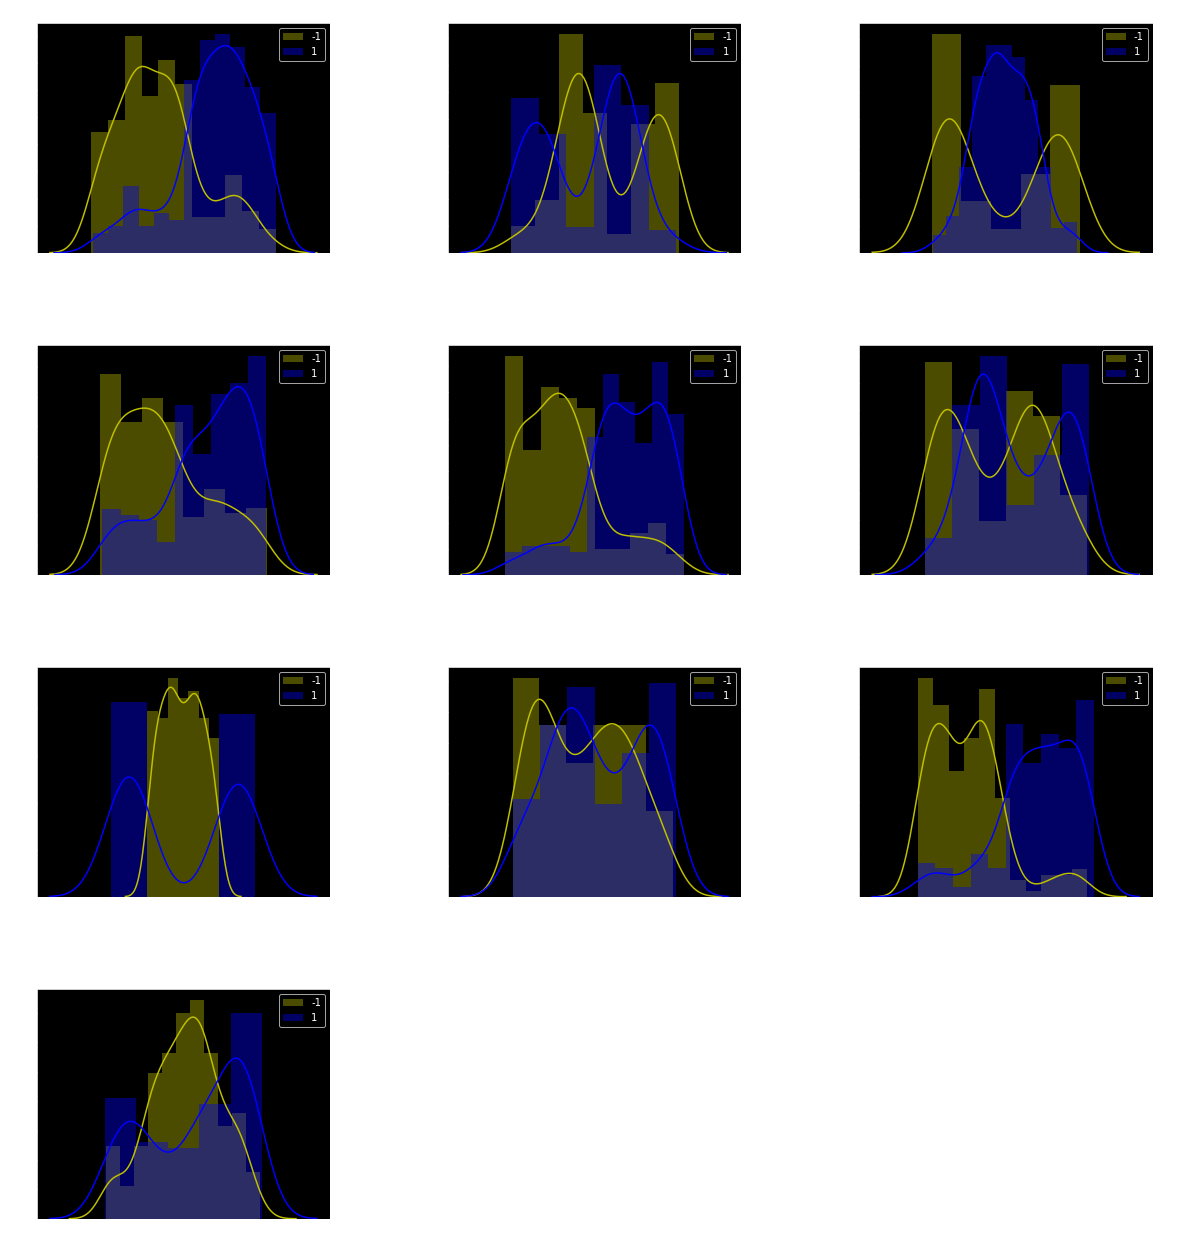

In [14]:
plt.figure(figsize=(20,22))
for i,col in enumerate(sensor.columns[1:]):
    plt.subplot(4,3,i+1)
    sns.distplot(sensor[col][sensor['class_label']==-1], color='y',label='-1')
    sns.distplot(sensor[col][sensor['class_label']==1], color='b',label='1')
    plt.title(f'Histogram with KDE between class 1 and -1 for {col}')
    plt.subplots_adjust(wspace=0.4,hspace=0.4)
    plt.legend()
plt.show()

sensor0,sensor4 and sensor8 have majority of the class_label -1 to be between 0 to 0.5 and from 0.5 to 1 for class_label 1
Sensor6 has 0 to .25 and 0.75 to 1.00 of class_label 1 and 0.25 to 0.75 data points representing class_label -1

These feature variables with the given data clearly dominates the other features in terms of representing the class_label. 

In [15]:
x = sensor.iloc[:,1:]
y = sensor.iloc[:,0]
x.shape,y.shape

((400, 10), (400,))

In [17]:
sel = SelectKBest(chi2,k=10)
sel.fit_transform(x,y)

array([[0.83425098, 0.7260814 , 0.53590368, ..., 0.5575265 , 0.59964966,
        0.66556879],
       [0.80405917, 0.25313516, 0.86986731, ..., 0.19418983, 0.01496617,
        0.80291781],
       [0.69440428, 0.59577657, 0.58129427, ..., 0.0071863 , 0.65963303,
        0.83100877],
       ...,
       [0.320118  , 0.44495092, 0.40189648, ..., 0.23074904, 0.20461176,
        0.55888867],
       [0.05913231, 0.33742625, 0.7728472 , ..., 0.03583906, 0.25872336,
        0.7099579 ],
       [0.37977772, 0.46025638, 0.22925675, ..., 0.54632414, 0.36312656,
        0.17663207]])

In [18]:
val = sorted([i for i in zip(x.columns,sel.pvalues_.round(2),sel.scores_.round(2))],key=lambda x: x[2],reverse=True)

In [19]:
val

[('sensor8', 0.0, 31.64),
 ('sensor4', 0.0, 24.58),
 ('sensor0', 0.0, 16.18),
 ('sensor3', 0.0, 13.05),
 ('sensor1', 0.05, 3.81),
 ('sensor5', 0.07, 3.31),
 ('sensor7', 0.15, 2.04),
 ('sensor9', 0.48, 0.49),
 ('sensor2', 0.75, 0.1),
 ('sensor6', 0.95, 0.0)]

Based on the above chi scores. Sensor8,sensor4,sensor0 and sensor3 has a very low pvalue(assuming we keep 0.05 as statistifically significant) from which we can infer that there is a relation between the class label and the features. 

We can try to use the 4 sensor data to predict the class using various algorithm to see if we can get a higher accuracy. We can also include sensor1 as it might provide more information to predict the given class. 

In [20]:
x_sel = x[['sensor8','sensor4','sensor0','sensor3','sensor1']]

We could do a stratified split however in our case the classes are evenly distributed across the 400 observation. 

In [46]:
split = StratifiedShuffleSplit(n_splits=5,test_size=0.2)

In [47]:
for train_index,test_index in split.split(x_sel,y):
    strain_set = x_sel.loc[train_index]
    stest_set = x_sel.loc[test_index]
strain_set.shape,stest_set.shape

((320, 5), (80, 5))

In [29]:
split = StratifiedKFold(n_splits=3,random_state=46)
for train_index,test_index in split.split(x_sel,y):
    sx_train, sy_train = x_sel.iloc[train_index], y.iloc[train_index]
    sx_test, sy_test = x_sel.iloc[test_index], y.iloc[test_index]
print(sx_train.shape,sy_train.shape)
print(sx_test.shape,sy_test.shape)

(268, 5) (268,)
(132, 5) (132,)


In [25]:
sgd_clf = SGDClassifier(loss='log',penalty='elasticnet',random_state=46,shuffle=True)

In [26]:
sgd_clf.fit(x_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=46, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [27]:
y_pred = sgd_clf.predict(x_test)

In [28]:
sum(y_test == y_pred) / len(y_test)

0.9125

based on the above features we got a accuracy of 91 percent with 5 features. Let's perform cross validation to see if we get a consistent 91 percent across all the test data. 

In [ ]:
forest_clf = RandomForestClassifier(random_state=46)

In [ ]:
y_pred = forest_clf.predict(sx_test)

In [ ]:
sum(sy_test == y_pred) / len(sy_test)

In [30]:
pipe = Pipeline([
#                  ('poly',PolynomialFeatures(degree=2,include_bias=True)),
#                  ('scalar',StandardScaler()),
                  ('sdg',SGDClassifier(loss='log',penalty='elasticnet',random_state=46,shuffle=True))
])

In [31]:
pipe.fit(sx_train,sy_train)

Pipeline(memory=None,
         steps=[('sdg',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='log',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
                               penalty='elasticnet', power_t=0.5,
                               random_state=46, shuffle=True, tol=0.001,
                               validation_fraction=0.1, verbose=0,
                               warm_start=False))],
         verbose=False)

In [32]:
y_pred = pipe.predict(sx_test)

In [33]:
sum(sy_test == y_pred)/len(sy_test)

0.9090909090909091

In [34]:
cross_val_score(pipe,sx_train,sy_train,scoring='accuracy',cv=8,n_jobs=-1).mean()

0.8922334558823529

In [ ]:
sgd_clf.get_params().keys()

In [ ]:
params = [{'alpha':10.0**-np.arange(1,6),
           'penalty':['l1','l2','elasticnet'],
           'shuffle':[True,False]
          }]

In [ ]:
10.0**-np.arange(1,6)

In [ ]:
params = [{'n_estimators':np.arange(1,20),
          'class_weight':['balanced','balanced_subsample',None],
          'max_features':np.arange(3,10),
          'max_depth':None,
           'min_samples_split':np.arange(2,5)
          }]

In [ ]:
estimator = GridSearchCV(sgd_clf,params,scoring='accuracy',n_jobs=-1,
                         cv=5,return_train_score=True)

In [ ]:
estimator.fit(sx_train,sy_train)

In [ ]:
estimator.best_estimator_

In [ ]:
estimator.best_params_

In [ ]:
cross_val_score(estimator.best_estimator_,sx_train,sy_train,scoring='accuracy',cv=5).mean()

In [ ]:
estimator.best_estimator_.fit(sx_train,sy_train)

In [ ]:
y_pre = estimator.best_estimator_.predict(sx_test)

In [ ]:
sum(sy_test == y_pre) /len(sy_test)

In [ ]:
estimator.best_estimator_.feature_importances_

In [ ]:
indicies = np.argsort(estimator.best_estimator_.feature_importances_)[::-1]

In [ ]:
[x.columns[i] for i in indicies]

In [ ]:
x.columns,estimator.best_estimator_.feature_importances_

In [ ]:
forest_clf.fit(x_train[['sensor6','sensor4']],y_train)

In [ ]:
y_p = forest_clf.predict(x_test[['sensor6','sensor4']])

In [ ]:
sum(y_test == y_p) / len(y_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2)

In [ ]:
knn.fit(x_train[['sensor6','sensor4']],y_train)

In [ ]:
y_pred = knn.predict(x_test[['sensor6','sensor4']])

In [ ]:
sum(y_test == y_pred) / len(y_test)